# Proposal Generation
1. Instance Mask Generation by SAM
2. Center-crop the instance proposal w/ or w/o background

In [1]:
import cv2
import csv
import glob
import json
import math
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append("../segment-anything")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sys.path.append(".")
from utils.data_utils import gen_square_crops

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

image_dir = "./test_data/test_1/test_002.jpg"
output_dir = "./exps/vis_proposals"

#### 1. Instance Mask Generation by SAM

In [2]:
# read test image and resize to low-resolution
raw_image = cv2.cvtColor(cv2.imread(image_dir), cv2.COLOR_BGR2RGB)
ratio = 0.25
scene_image = cv2.resize(raw_image, (int(raw_image.shape[1] * ratio), int(raw_image.shape[0] * ratio)), cv2.INTER_LINEAR)

# initialize sam
sam_checkpoint = "configs/sam_vit_l_0b3195.pth"
model_type = "vit_l"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

mask_generator = SamAutomaticMaskGenerator(sam)

# generate masks
masks = mask_generator.generate(scene_image)

#### 2. Center-crop the instance proposals

In [3]:
image_height, image_width = raw_image.shape[:-1]
scene_name = os.path.basename(image_dir).split('.')[0]

# rois_mask = []
# rois_bbox = []
for ind, segment_dict in enumerate(masks):
    
    # bbox
    x0 = int(segment_dict['bbox'][0])
    y0 = int(segment_dict['bbox'][1])
    x1 = int(segment_dict['bbox'][0]) + int(segment_dict['bbox'][2])
    y1 = int(segment_dict['bbox'][1]) + int(segment_dict['bbox'][3])

    # scale up to adapt on raw image size
    if ratio != 0:
        x0 = int(x0 // ratio)
        y0 = int(y0 // ratio)
        x1 = int(x1 // ratio)
        y1 = int(y1 // ratio)

    # load mask
    mask = segment_dict['segmentation']

    # invert background to white
    new_image = Image.new('RGB', size=(image_width, image_height), color=(255, 255, 255))
    new_image.paste(Image.fromarray(raw_image), (0, 0), mask=Image.fromarray(mask).resize((image_width, image_height)))

    # crop by mask
    roi_mask = gen_square_crops(new_image, [x0, y0, x1, y1]) 
    # rois_mask.append(roi_mask)
    # crop by bbox
    roi_bbox = gen_square_crops(Image.fromarray(raw_image), [x0, y0, x1, y1]) 
    # rois_bbox.append(roi_bbox)
    
    
    # save roi region
    os.makedirs(os.path.join(output_dir, scene_name + '_mask'), exist_ok=True)
    roi_mask.save(os.path.join(output_dir, scene_name + '_mask', scene_name + '_' + str(ind).zfill(3) + '.png'))
    
    os.makedirs(os.path.join(output_dir, scene_name + '_bbox'), exist_ok=True)
    roi_bbox.save(os.path.join(output_dir, scene_name + '_bbox', scene_name + '_' + str(ind).zfill(3) + '.png'))



#### 3. Visualization on instance proposals w/ and w/o background

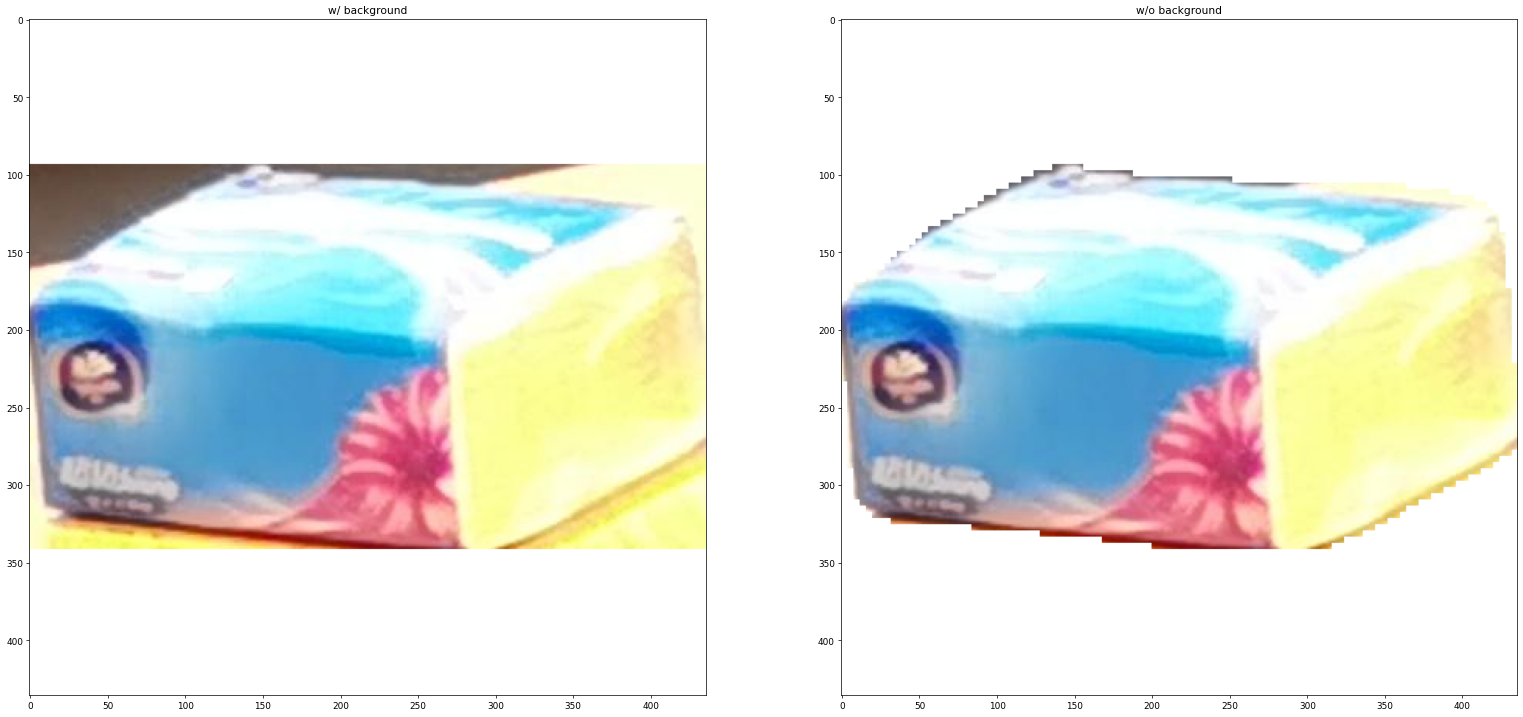

In [4]:
roi_mask = Image.open(os.path.join(output_dir, scene_name + '_mask', 'test_002_013.png'))
roi_bbox = Image.open(os.path.join(output_dir, scene_name + '_bbox', 'test_002_013.png'))

fig = plt.figure(figsize=(30, 15), dpi=64, facecolor='w', edgecolor='k')
ax = plt.subplot(121)
ax.set_title("w/ background")
plt.imshow(np.asarray(roi_bbox))
ax = plt.subplot(122)
ax.set_title("w/o background")
plt.imshow(np.asarray(roi_mask))
plt.show()